In [1]:
import pandas as pd
import numpy as np
import json
import codecs
import preprocessing_tools as pr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score,KFold

## Два класса: positive, negative

## Три класса: positive, neutral, negative

In [2]:
train = pd.read_json('train.json',encoding = 'UTF-8')
# Заменяем позитивный маркер на 1, негативный на -1, нейтральный на 0
train['sentiment'] = train['sentiment'].replace(['positive' ,'neutral','negative'],[1,0,-1])
# задаем целевую переменную
target = train['sentiment']

In [3]:
print(len(train))
print(len(train[train.sentiment == 1]))
print(len(train[train.sentiment == -1]))
print(len(train[train.sentiment == 0]))

8263
2795
1434
4034


In [4]:
test_data = pd.read_json('test.json',encoding = 'UTF-8')

In [5]:
train.head()

,id,sentiment,text
0,1945,-1,Досудебное расследование по факту покупки ЕНПФ...
1,1957,-1,Медики рассказали о состоянии пострадавшего му...
2,1969,-1,"Прошел почти год, как железнодорожным оператор..."
3,1973,-1,По итогам 12 месяцев 2016 года на территории р...
4,1975,-1,Астана. 21 ноября. Kazakhstan Today - Агентств...


# Визуализация признаков 

## Без предобработки

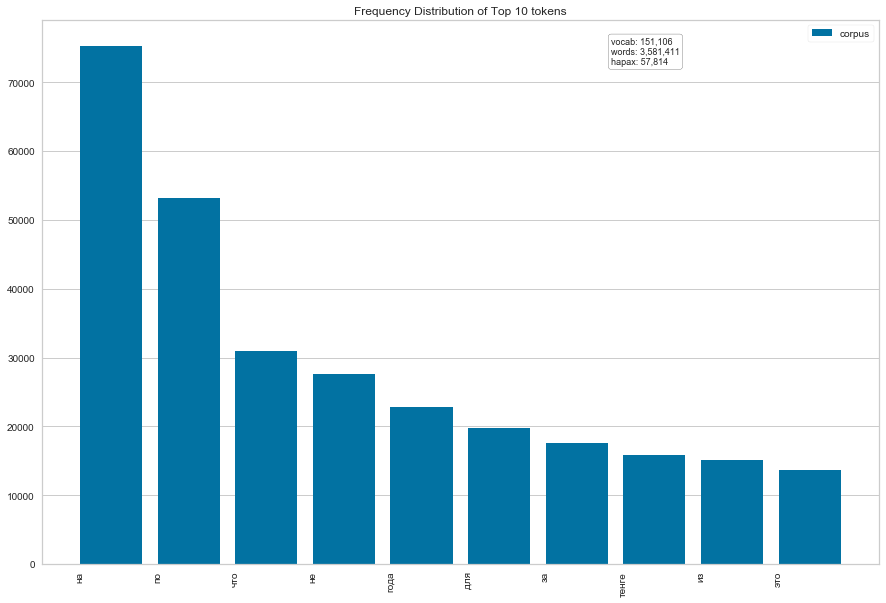

In [11]:
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(train['text'])
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

## С предобработкой

In [12]:
# убираем стоп-слова, чтобы визуализировать
train_vis = train['text'].apply(pr.clean_text)
train_vis = train['text'].apply(pr.stop_words_remove)

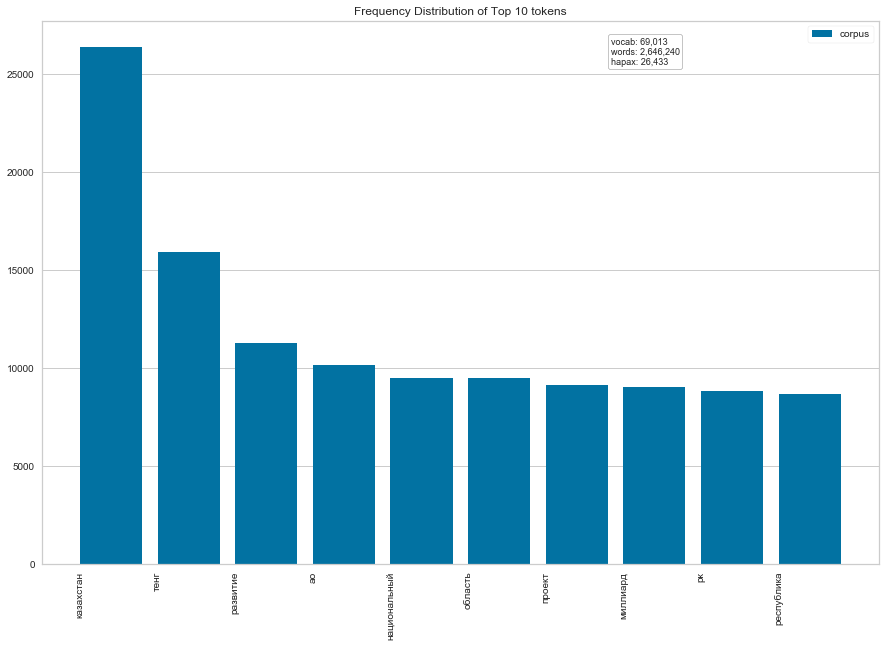

In [13]:
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(train_vis)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

# Очищаем текст и лемматизируем


In [9]:
%reload_ext autoreload
train['text'] = train['text'].apply(pr.clean_text)
test_data['text'] = test_data['text'].apply(pr.clean_text)
train['lemmas'] = train['text'].apply(pr.lemmatization)
test_data['lemmas'] = test_data['text'].apply(pr.lemmatization)

In [10]:

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(train['lemmas'])
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n= 10, orient = 'v', size=(1080, 720))
visualizer.fit(docs)
visualizer.poof()

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
train.head()

# Модель

In [ ]:
train['lemmas'] = train['lemmas'].apply(str)
test_data['lemmas'] = test_data['text'].apply(str)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(encoding='cp1251')

# Logistic Regression

## С использованием лемм

In [ ]:
# точность может варьироваться в зависимости от того, как произошло рабиение на обучающую и тестовую выборки
tfidf_vectorizer.fit(train['lemmas'])

X = tfidf_vectorizer.transform(train['text'])
X_lemmas = tfidf_vectorizer.transform(train['lemmas'])
X_train, X_test, y_train, y_test = train_test_split(
    X_lemmas, target, train_size = 0.75, random_state = 1
)

cross_val_scale = []
mean_cross_val_scale =[]

partition_generator = KFold(n_splits=5, shuffle=True, random_state=42)


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    cross_val_result = cross_val_score(lr, X_lemmas, target, cv=partition_generator)
        #составляем массив из средних арифметиеских кросс валидации c масштабированием признаков
    cross_val_scale.append(cross_val_result)
    mean_cross_val_scale.append(np.mean(cross_val_result))
    print(max(mean_cross_val_scale))

In [ ]:
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf.predict(X_test)))

## Без использования лемм

In [ ]:
# точность может варьироваться в зависимости от того, как произошло рабиение на обучающую и тестовую выборки
tfidf_vectorizer.fit(train['text'])

X = tfidf_vectorizer.transform(train['text'])
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75, random_state = 1
)

cross_val_scale = []
mean_cross_val_scale =[]

partition_generator = KFold(n_splits=5, shuffle=True, random_state=42)


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    cross_val_result = cross_val_score(lr, X, target, cv=partition_generator)
        #составляем массив из средних арифметиеских кросс валидации c масштабированием признаков
    cross_val_scale.append(cross_val_result)
    mean_cross_val_scale.append(np.mean(cross_val_result))
    print(max(mean_cross_val_scale))

In [ ]:
from sklearn import metrics 
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_val, final_tfidf.predict(X_val)))
print (metrics.classification_report(y_val,final_tfidf.predict(X_val)))

# SVM

## Без использования лемм

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(train['text'])
X = ngram_vectorizer.transform(train['text'])
X_test = ngram_vectorizer.transform(test_data['text'])

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
    
final_svm_ngram = LinearSVC(C=0.01)
final_svm_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_svm_ngram.predict(X)))
print (metrics.classification_report(target,final_tfidf.predict(X)))

## Смешанные подходы

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(train['text'])
X = ngram_vectorizer.transform(train['text'])
X_test = ngram_vectorizer.transform(test_data['text'])

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
    
final = LinearSVC(C=0.01)
final.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final.predict(X_test)))

## Что-то

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(train['lemmas'])
X = ngram_vectorizer.transform(train['lemmas'])
#X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_test, y_train, y_test = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    

    
final_ngram = LogisticRegression(C=0.5)
final_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_ngram.predict(X_test)))

